In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Util function**

In [2]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [42]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_encoder_cond_pbmc68k/dac62395-057d-441c-941a-928c697356b7/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [43]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["celltype"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 4.9195e-39,  4.9072e-39, -4.9211e-39,  4.9242e-39,  4.9089e-39,
         -4.9311e-39, -4.9135e-39, -4.9165e-39, -4.9115e-39,  4.9368e-39,
          4.9172e-39,  4.9436e-39,  4.9236e-39,  4.9422e-39,  4.9279e-39,
         -4.9432e-39, -4.9094e-39, -4.9075e-39,  4.9273e-39,  4.9451e-39,
         -4.9146e-39,  4.9317e-39,  4.9380e-39,  4.9218e-39, -4.9408e-39,
          4.9261e-39,  4.9166e-39, -4.9246e-39,  4.9191e-39,  4.9221e-39,
          4.9408e-39,  4.9087e-39],
        [ 4.9063e-39,  4.9117e-39, -4.9152e-39, -4.9439e-39, -4.9348e-39,
         -4.9374e-39,  4.9113e-39,  4.9268e-39, -4.9264e-39,  4.9322e-39,
          4.9318e-39, -4.9210e-39, -4.9155e-39,  4.9370e-39, -4.9401e-39,
          4.9362e-39, -4.9360e-39, -4.9419e-39,  4.9323e-39,  4.9279e-39,
          4.9078e-39, -4.9436e-39, -4.9186e-39, -4.9102e-39, -4.9149e-39,
         -4.9282e-39, -4.9386e-39,  4.9253e-39,  4.9052e-39,  4.9380e-39,
         -4.9393e-39, -4.9370e-39],
        [-4.9125e-

In [44]:
dataset_config = {'dataset_path': '../../datasets/processed/pbmc68k.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['celltype'],
                    'sampling_covariate': 'celltype',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_encoder',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 32}

generative_model_config = {'x0_from_x_kwargs': {
                                'dims': [512, 512],
                                'batch_norm': True,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'scaling_method': 'log_normalization',
                            'pretrain_encoder': True,
                            'pretraining_encoder_epochs': 200,
                            'sigma': 0.5,
                            'covariate_specific_theta': False
                        }

**Initialization**

Initialize dataset 

In [45]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        target_max=dataset_config["target_max"], 
                        target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

Initialize VDM 

In [46]:
generative_model = FM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=None,
            encoder_type=dataset_config["encoder_type"],
            model_type=denoising_model.model_type,
            conditioning_covariate="cell_type",
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (denoising_model): MLPTimeStep(
    (time_embedder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): SiLU()
    )
    (size_factor_embedder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): SiLU()
    )
    (condition_embedder): Sequential(
      (0): Linear(in_features=32, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): SiLU()
    )
    (net_in): Linear(in_features=2000, out_features=128, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x ResnetBlock(
        (net1): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=T

**Check the data**

In [47]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

**Collect checkpoints and run**

General conditional

In [48]:
num_indices = 10000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes =  list(adata_indices.obs.celltype)
classes = torch.tensor([dataset.id2cov["celltype"][c] for  c in classes]).cuda()

log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [49]:
X_generated = generative_model.batched_sample(batch_size=1000,
                                                repetitions=10,
                                                n_sample_steps=100, 
                                                covariate="celltype", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

X_generated = X_generated.to("cpu")

Single condition

In [50]:
# dataset.id2cov["cell_type"]

In [51]:
# # Pick condition 
# condition_name = 'B cell'
# condition_val = dataset.id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()

# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [52]:
# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=500, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated = X_generated.to("cpu")

**Create adata and check plots**

In [53]:
adata_generated = sc.AnnData(X=deepcopy(X_generated).cpu().numpy())

In [54]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

In [55]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

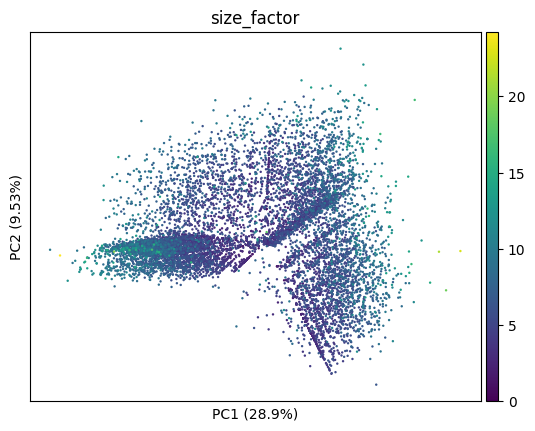

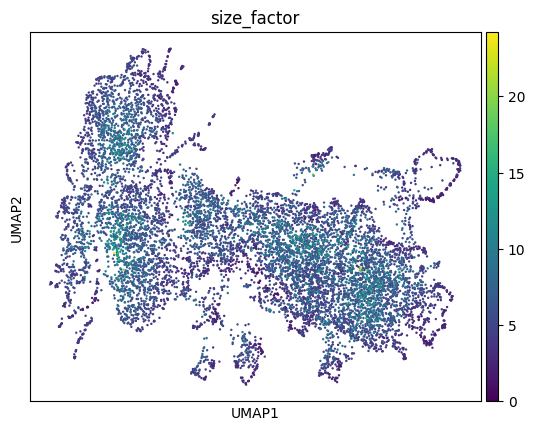

In [56]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color="size_factor")

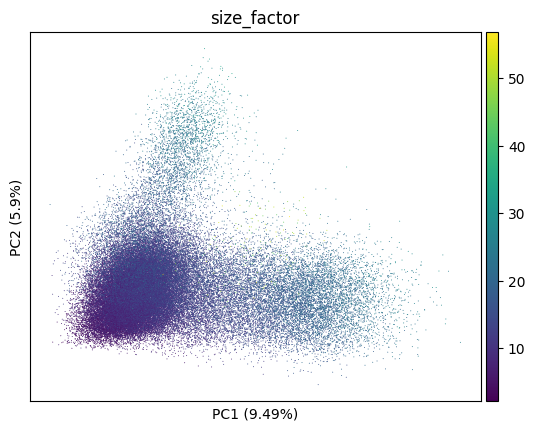

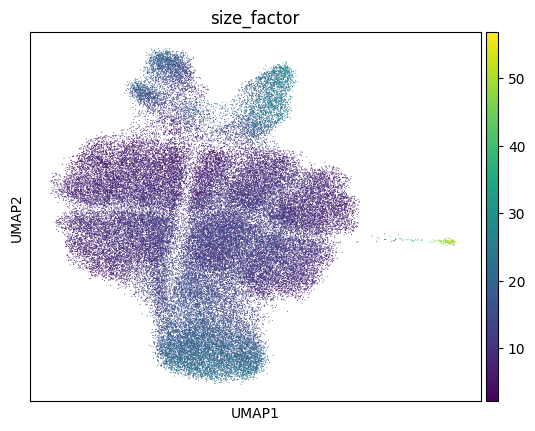

In [57]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

Merge and plot the generated and real data

In [58]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]

In [59]:
# # If applicable 
# cell_type = list(adata_original.obs.cell_type) + [condition_name for _ in range(X_generated.shape[0])]
# dataset_type["cell_type"] = cell_type

In [60]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [61]:
adata_original

AnnData object with n_obs × n_vars = 64843 × 2000
    obs: 'celltype', 'size_factor'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [62]:
# sc.pp.normalize_total(adata_merged) 
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

In [63]:
# sc.pl.pca(adata_merged, color=["dataset_type", "cell_type"],  annotate_var_explained=True)
# sc.pl.umap(adata_merged, color=["dataset_type", "cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


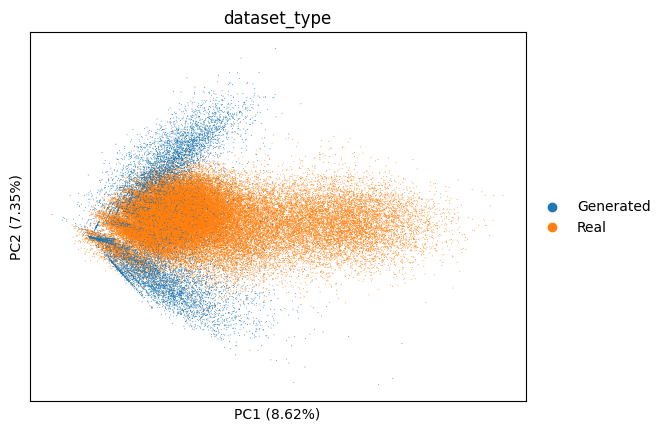

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


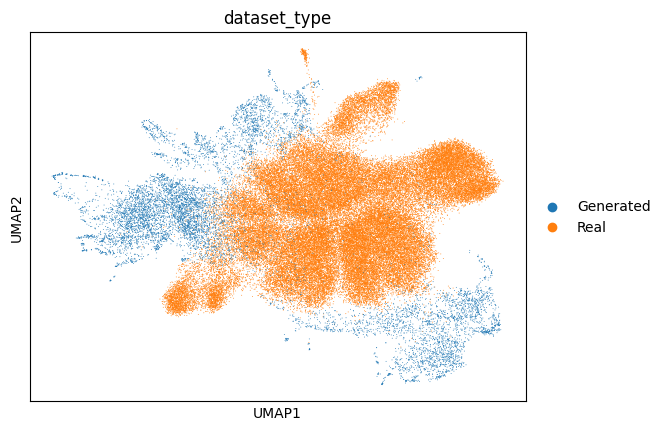

In [73]:
sc.pl.pca(adata_merged, color=["dataset_type"],  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["dataset_type"])

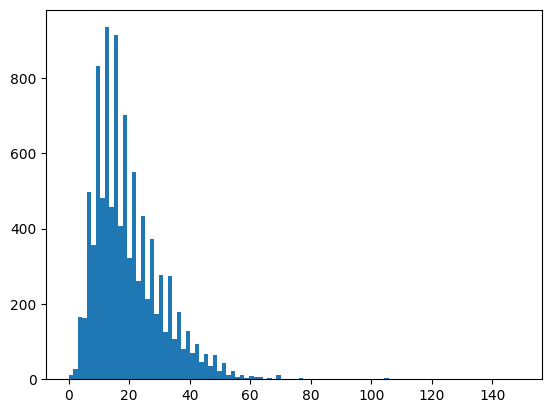

In [65]:
plt.hist(X_generated.sum(1), 100)
plt.show()

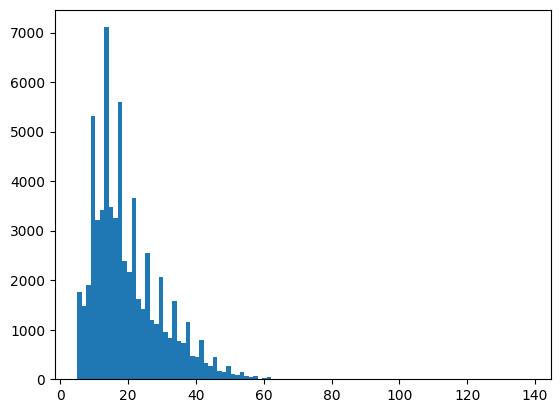

In [66]:
plt.hist(X.sum(1), 100)
plt.show()

In [67]:
(X_generated==0).sum(1).float().mean()

tensor(1996.1620)

In [68]:
(X==0).sum(1).float().mean()

tensor(1987.0918)

In [69]:
X.mean(1).mean()

tensor(0.0099)

In [70]:
X_generated.mean(1).mean()

tensor(0.0098)

**Check original data**

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


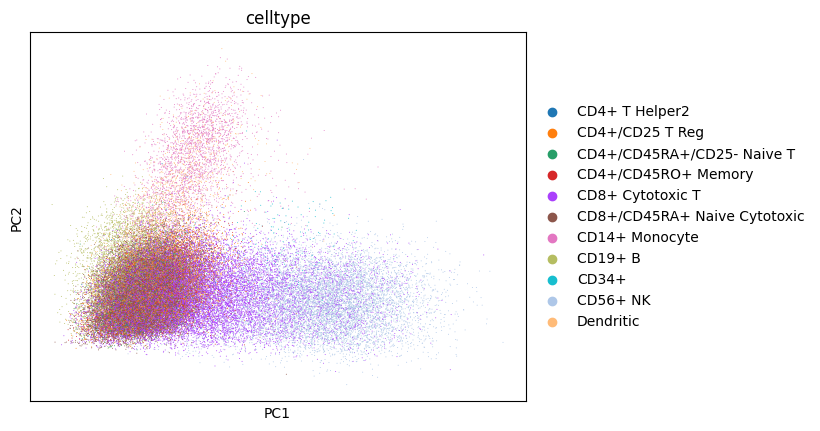

In [71]:
sc.pl.pca(adata_original, color="celltype")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


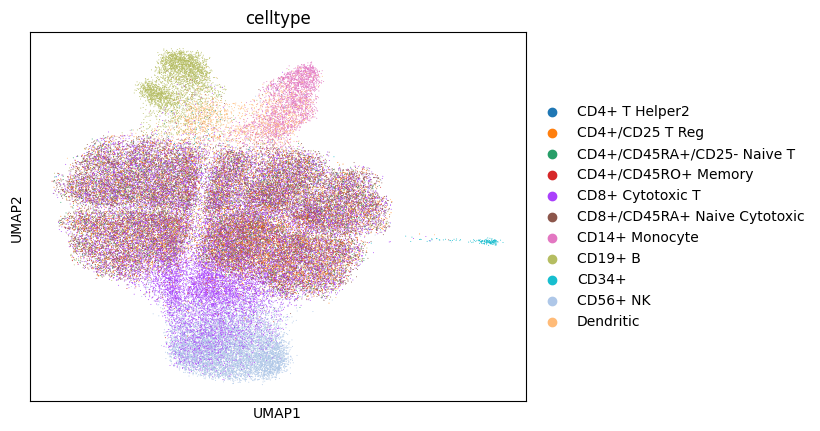

In [72]:
sc.pl.umap(adata_original, color="celltype")